In [285]:
import torchvision.transforms as T

from transformers import ViTImageProcessor, ViTModel
from transformers import AutoFeatureExtractor, AutoModel

from tqdm.auto import tqdm

import matplotlib.pyplot as plt

import requests
import glob
import keras
import tensorflow
import torch

import numpy as np
import random
import pandas as pd
import csv
import PIL
import io

import pyarrow as pa
import pyarrow.dataset as ds

from datasets import load_dataset, Features, Image, Dataset


In [13]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


## Dataset construction

In [ ]:
data_path = '/media1/data/beardata/2021/2021_bodies/2021_singles'

In [210]:
bears = load_dataset("imagefolder", data_dir=data_path)

# We don't need the 'label' feature but let's keep it in case we need it in the futur
bears

Resolving data files:   0%|          | 0/10632 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /home/claire/.cache/huggingface/datasets/imagefolder/default-5dbafc84e204888f/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 10626
    })
})

In [259]:
labels = bears["train"].features["label"].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [269]:
print(bears['train'].features)
filenames = glob.glob(data_path + '/**/*.JPG', recursive=True)

num_samples = 100
candidate_subset = bears["train"].shuffle(seed=42).select(range(num_samples))

print(f"Format of the images: {candidate_subset[0]['image']}")
print(f'The sample has size {len(candidate_subset)}')


Loading cached shuffled indices for dataset at /home/claire/.cache/huggingface/datasets/imagefolder/default-5dbafc84e204888f/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-c76a01d20813be3d.arrow


{'image': Image(decode=True, id=None), 'label': ClassLabel(names=['Aardvark', 'Apeman', 'Battle', 'Bearded_Lady', 'Bent_Left_Ear', 'Big_Dude', 'Big_Ears', 'Big_Head', 'Bobber', 'Braveheart', 'Cee', 'Chaser_Girl', 'Chops', 'Crease', 'Donnie', 'Dune_bear', 'Dusty', 'Ears', 'Goblin', 'Goucho', 'Hemi', 'Herman', 'Holden', 'Hotlips', 'Ian', 'L', 'Lax', 'Long_Claw', 'Mask', 'Mason', 'Mumford', 'Not_Ears', 'Not_Elvis', 'Old_Bear', 'Other_Popeye', 'Panda', 'Pintail', 'Point', 'Revlon', 'Rocky', 'Saalfeld', 'Saddle_female', 'Seuss', 'Sideline', 'Simba', 'Sister', 'Sloth', 'Smiley', 'Smirk', 'Snaggletooth', 'TESL', 'T_bear', 'Ted_like', 'That_Bear', 'The_Mountain', 'Tina_Fey', 'Waterfalls', 'Wayback'], id=None)}
Format of the images: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2182x3244 at 0x7F339A0B1310>
The sample has size 100


## Model

In [3]:
model_ckpt = "nateraw/vit-base-beans"
extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

/home/claire/miniconda3/envs/pytorch/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Some weights of the model checkpoint at nateraw/vit-base-beans were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at nateraw/vit-base-beans and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
transformation_chain = T.Compose(
    [
        # We first resize the input image to 256x256 and then we take center crop.
        T.Resize(int((256 / 224) * extractor.size["height"])),
        T.CenterCrop(extractor.size["height"]),
        T.ToTensor(),
        T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
    ]
)

In [221]:
def extract_embeddings(model: torch.nn.Module):
    """Utility to compute embeddings."""
    device = model.device
    print(f"Device: {device}")

    def pp(batch):
        images = batch["image"]
        print(images[0])
        # `transformation_chain` is a compostion of preprocessing
        # transformations we apply to the input images to prepare them
        # for the model. For more details, check out the accompanying Colab Notebook.
        image_batch_transformed = torch.stack([transformation_chain(image) for image in images])
        new_batch = {"pixel_values": image_batch_transformed.to(device)}
        with torch.no_grad():
            embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()
        return {"embeddings": embeddings}

    return pp

In [270]:
# Here, we map embedding extraction utility on our subset of candidate images.
batch_size = 24
device = "cuda" if torch.cuda.is_available() else "cpu"

extract_fct = extract_embeddings(model.to(device))
candidate_subset_emb = candidate_subset.map(extract_fct, batched=True, batch_size=24)

Device: cuda:0


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2182x3244 at 0x7F338B75F940>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2426x2302 at 0x7F3398C6B9A0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1854x1548 at 0x7F3398C6B940>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=747x586 at 0x7F3398C6BCA0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3047x3347 at 0x7F3398C6BC70>


In [284]:
(candidate_subset_emb[0]['embeddings'])

[-0.06734010577201843,
 0.05405532568693161,
 -0.11548574268817902,
 -0.06782195717096329,
 -0.04137865826487541,
 0.07878892868757248,
 0.0907585397362709,
 0.4341665208339691,
 0.07461744546890259,
 -0.24439862370491028,
 -0.11602174490690231,
 0.11624518781900406,
 -0.05422129109501839,
 0.14324304461479187,
 -0.19215922057628632,
 -0.007341605611145496,
 0.11440550535917282,
 -0.14514079689979553,
 0.015852777287364006,
 -0.11079519987106323,
 -0.13618911802768707,
 0.07536156475543976,
 -0.03288629651069641,
 -0.06481054425239563,
 -0.04172646999359131,
 -0.023087764158844948,
 -0.05818091332912445,
 0.1482333242893219,
 0.022041304036974907,
 -0.06981115788221359,
 0.2690192759037018,
 -0.07801591604948044,
 -0.07705044746398926,
 -0.06556902080774307,
 -0.14884212613105774,
 -0.007412691600620747,
 0.009701061062514782,
 0.16606442630290985,
 -0.08729463815689087,
 -0.012006053701043129,
 -0.07366760075092316,
 0.0010291605722159147,
 0.011035457253456116,
 -0.35411083698272705,

## Write TSV file with all embeddings

In [ ]:
with open('output.tsv', 'w', newline='') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\t')
    tsv_output.writerow(candidate_subset_emb)

In [272]:
candidate_ids = []

for id in tqdm(range(len(candidate_subset_emb))):
    label = candidate_subset_emb[id]["label"]

    # Create a unique indentifier.
    entry = str(id) + "_" + str(label)

    candidate_ids.append(entry)

  0%|          | 0/100 [00:00<?, ?it/s]

In [273]:
all_candidate_embeddings = np.array(candidate_subset_emb["embeddings"])
all_candidate_embeddings = torch.from_numpy(all_candidate_embeddings)

In [274]:
def compute_scores(emb_one, emb_two):
    """Computes cosine similarity between two vectors."""
    scores = torch.nn.functional.cosine_similarity(emb_one, emb_two)
    return scores.numpy().tolist()

In [260]:
def fetch_similar(image, top_k=5):
    """Fetches the `top_k` similar images with `image` as the query."""
    # Prepare the input query image for embedding computation.
    image_transformed = transformation_chain(image).unsqueeze(0)
    new_batch = {"pixel_values": image_transformed.to(device)}

    # Comute the embedding.
    with torch.no_grad():
        query_embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()

    # Compute similarity scores with all the candidate images at one go.
    # We also create a mapping between the candidate image identifiers
    # and their similarity scores with the query image.
    sim_scores = compute_scores(all_candidate_embeddings, query_embeddings)
    similarity_mapping = dict(zip(candidate_ids, sim_scores))
 
    # Sort the mapping dictionary and return `top_k` candidates.
    similarity_mapping_sorted = dict(
        sorted(similarity_mapping.items(), key=lambda x: x[1], reverse=True)
    )
    id_entries = list(similarity_mapping_sorted.keys())[:top_k]

    ids = list(map(lambda x: int(x.split("_")[0]), id_entries))
    labels = list(map(lambda x: int(x.split("_")[-1]), id_entries))

    return ids, labels

In [265]:
def plot_images(images, labels):
    if not isinstance(labels, list):
        labels = labels.tolist()

    plt.figure(figsize=(20, 10))
    columns = 6
    for (i, image) in enumerate(images):
        label_id = int(labels[i])
        ax = plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + "Label: {}".format(id2label[label_id]))
        else:
            ax.set_title(
                "Similar Image # " + str(i) + "\nLabel: {}".format(id2label[label_id])
            )
        plt.imshow(np.array(image).astype("int"))
        plt.axis("off")


Query label: 41
Top 5 candidate labels: [41, 19, 15, 30, 19]


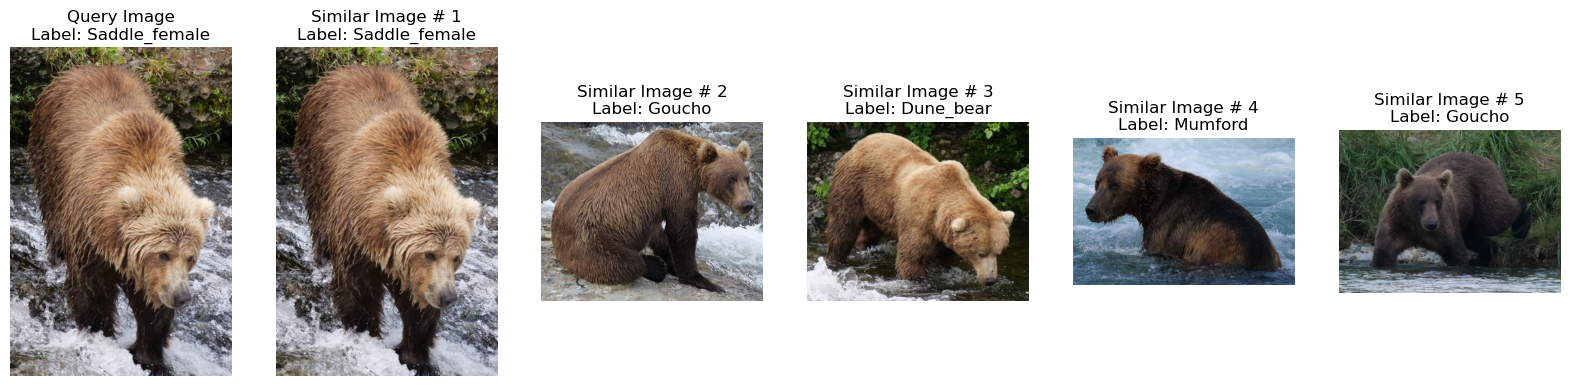

In [277]:
images = []
labels = []

test_sample = candidate_subset['image'][0]
test_label = candidate_subset['label'][0]

sim_ids, sim_labels = fetch_similar(test_sample, top_k=5)

print(f"Query label: {test_label}")
print(f"Top 5 candidate labels: {sim_labels}")


for id, label in zip(sim_ids, sim_labels):
    images.append(candidate_subset_emb[id]["image"])
    labels.append(candidate_subset_emb[id]["label"])

images.insert(0, test_sample)
labels.insert(0, test_label)
plot_images(images, labels)